In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [45]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [46]:
def readLangs(lang1, lang2, reverse=False):
    # File path is static; no formatting needed
    lines = open('/kaggle/input/hin-eng/hin.txt', encoding='utf-8') \
        .read().strip().split('\n')

    # Split each line into a pair (input and output sentence)
    pairs = [[s for s in l.split('\t')] for l in lines]

    # Reverse pairs if needed
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    return lang1, lang2, pairs

In [47]:
import random
import re

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


# Function to clean the sentence
def clean_sentence(sentence):
    # Remove non-breaking spaces and extra spaces
    sentence = sentence.replace("\u202f", " ").strip()
    
    # Remove unwanted punctuation but preserve Hindi matras and characters
    # This regex removes anything that is not a word or whitespace, but we allow Hindi characters
    sentence = re.sub(r'[^\w\s\u0900-\u097F]', '', sentence)  # Remove punctuation but keep Hindi characters
    return sentence


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    filtered = []
    for pair in pairs:
        if filterPair(pair):
            filtered.append(pair)
        else:
            print(f"Filtered out: {pair}")  # Debugging
    return filtered

# Updated Lang class with build_vocab
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1}  # Special tokens
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence.split(' '):
                if word not in self.word2index:
                    self.word2index[word] = self.n_words
                    self.index2word[self.n_words] = word
                    self.n_words += 1

# Updated prepareData function to apply cleaning, filtering, and vocab building
def prepareData(lang1, lang2, reverse=False):
    # Load the dataset
    with open('/kaggle/input/hin-eng/hin.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        print(f"Number of lines read from file: {len(lines)}")
        print(f"First 5 lines: {lines[:5]}")

    # Clean and preprocess dataset
    pairs = []
    for line in lines:
        if '\t' in line:
            parts = line.strip().split('\t')
            if len(parts) >= 2:  # Ensure at least two parts exist (eng, hin)
                eng, hin = parts[:2]
                pairs.append((eng, hin))  # Append as a tuple (eng, hin)

    print(f"Number of valid pairs after cleaning: {len(pairs)}")
    print(f"Sample pairs after cleaning: {pairs[:5]}")

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    # Create language objects
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    # Apply sentence cleaning
    pairs = [(clean_sentence(pair[0]), clean_sentence(pair[1])) for pair in pairs]

    # Apply filtering based on sentence length
    print(f"Number of pairs before filtering: {len(pairs)}")
    pairs = filterPairs(pairs)
    print(f"Number of pairs after filtering: {len(pairs)}")

    if len(pairs) == 0:
        print("Warning: No sentence pairs passed the filtering criteria!")

    # Build vocab after cleaning and filtering
    input_lang.build_vocab([pair[0] for pair in pairs])
    output_lang.build_vocab([pair[1] for pair in pairs])

    # Debugging vocab
    print(f"Input language vocabulary: {len(input_lang.word2index)}")
    print(f"Output language vocabulary: {len(output_lang.word2index)}")

    return input_lang, output_lang, pairs


# Run the updated code
input_lang, output_lang, pairs = prepareData('eng', 'hin', True)
if pairs:
    print(random.choice(pairs))  # Check if pairs are populated now
else:
    print("No pairs available to choose from.")


Number of lines read from file: 3061
First 5 lines: ['Wow!\tवाह!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)\n', 'Duck!\tझुको!\tCC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179041 (fastrizwaan)\n', 'Duck!\tबतख़!\tCC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179042 (fastrizwaan)\n', 'Help!\tबचाओ!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #459377 (minshirui)\n', 'Jump.\tउछलो.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179121 (fastrizwaan)\n']
Number of valid pairs after cleaning: 3061
Sample pairs after cleaning: [('Wow!', 'वाह!'), ('Duck!', 'झुको!'), ('Duck!', 'बतख़!'), ('Help!', 'बचाओ!'), ('Jump.', 'उछलो.')]
Number of pairs before filtering: 3061
Filtered out: ('मुझे पता है कि टॉम को नीन्द आ रही है।', 'I know Tom is sleepy')
Filtered out: ('मैं इतना थक गया हूँ कि मुझसे और चला नहीं जाएगा।', 'Im too tired to walk')
Filtered out: ('मुझे नौकरी से निकाला नहीं गया। मैंने ख

In [48]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [49]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [50]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [51]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        PAD_token = 0  # or another integer to represent padding

        # Set a maximum sequence length
        max_len = 10
        
        # Ensure inp_ids and tgt_ids are padded or truncated to max_len
        inp_ids = inp_ids[:max_len]  # truncate if necessary
        tgt_ids = tgt_ids[:max_len]  # truncate if necessary
        
        # Pad sequences if they are shorter than max_len
        while len(inp_ids) < max_len:
            inp_ids.append(PAD_token)  # Assuming PAD_token is defined
        while len(tgt_ids) < max_len:
            tgt_ids.append(PAD_token)  # Same for target
        
        # Now assign the padded or truncated sequences
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

        # target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [52]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [53]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [54]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [55]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [56]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [57]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [58]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Number of lines read from file: 3061
First 5 lines: ['Wow!\tवाह!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)\n', 'Duck!\tझुको!\tCC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179041 (fastrizwaan)\n', 'Duck!\tबतख़!\tCC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179042 (fastrizwaan)\n', 'Help!\tबचाओ!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #459377 (minshirui)\n', 'Jump.\tउछलो.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179121 (fastrizwaan)\n']
Number of valid pairs after cleaning: 3061
Sample pairs after cleaning: [('Wow!', 'वाह!'), ('Duck!', 'झुको!'), ('Duck!', 'बतख़!'), ('Help!', 'बचाओ!'), ('Jump.', 'उछलो.')]
Number of pairs before filtering: 3061
Filtered out: ('मुझे पता है कि टॉम को नीन्द आ रही है।', 'I know Tom is sleepy')
Filtered out: ('मैं इतना थक गया हूँ कि मुझसे और चला नहीं जाएगा।', 'Im too tired to walk')
Filtered out: ('मुझे नौकरी से निकाला नहीं गया। मैंने ख

In [60]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> तुम्हारी याददाश्त अच्छी है।
= You have a good memory
< You have a good memory to swim <EOS>

> उसने दिनों तक खाना नहीं खाया।
= He had to go without food for days
< He had to go without food for days <EOS>

> उसने उसका प्रस्ताव खुशी से स्वीकार कर लिया।
= She gladly accepted his proposal
< She gladly accepted his proposal <EOS>

> मुझे आपको संदेश देने के लिए कहा गया था।
= I was asked to give you a message
< I was asked to give you a message <EOS>

> तुम नहीं आ रहे हो ना
= Youre not coming are you
< You arent coming are you <EOS>

> मेरी नानी धीरेधीरे बोलतीं हैं।
= My grandmother speaks slowly
< My grandmother speaks slowly <EOS>

> उसके हिसाब से वह नहीं आ रही।
= According to him she is not coming
< According to him she is not coming <EOS>

> वे डूबते हुए जहाज़ से निकल गए।
= They abandoned the sinking ship
< They abandoned the sinking ship <EOS>

> मेरी उसके साथ पहली मुलाकात लंदन में हुई थी।
= I met her in London for the first time
< I met her in London for the first time <EOS>

> मैं अ

In [63]:
!apt-get install -y fonts-noto


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core fonts-noto-extra
  fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 9 newly installed, 0 to remove and 132 not upgraded.
Need to get 316 MB of archives.
After this operation, 788 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Get:4 h

In [64]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the font to Noto Sans Devanagari
rcParams['font.family'] = 'Noto Sans Devanagari'

# Now you can use your plotting code


input = तुम्हारी याददाश्त अच्छी है।
output = You have a good memory to swim <EOS>


<ipython-input-73-866e37283c7e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-73-866e37283c7e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


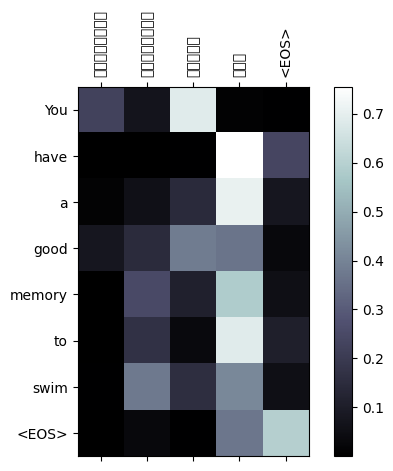

input = तुम नहीं आ रहे हो ना
output = You arent coming are you <EOS>


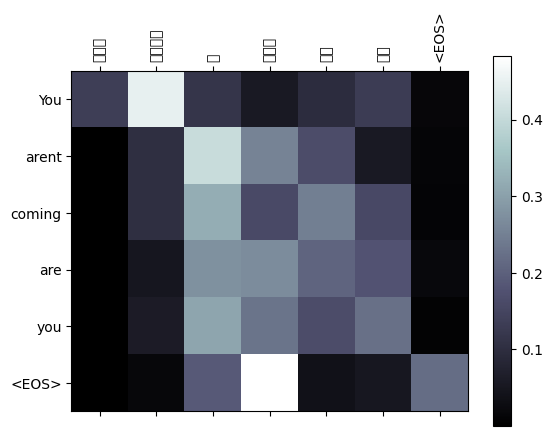

input = मेरी नानी धीरेधीरे बोलतीं हैं।
output = My grandmother speaks slowly <EOS>


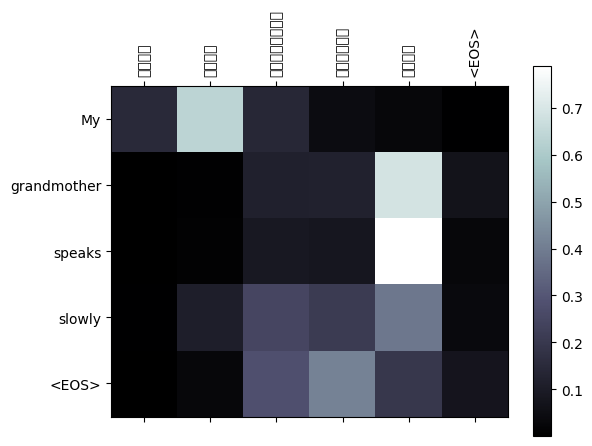

input = मैं अगले सोमवार आके ले जाऊंगा।
output = I had my stay at it myself <EOS>


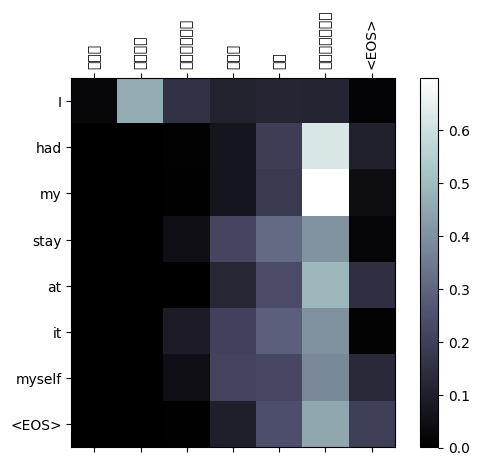

In [73]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('तुम्हारी याददाश्त अच्छी है।')

evaluateAndShowAttention('तुम नहीं आ रहे हो ना')

evaluateAndShowAttention('मेरी नानी धीरेधीरे बोलतीं हैं।')

evaluateAndShowAttention('मैं अगले सोमवार आके ले जाऊंगा।')

input = तुम्हारी याददाश्त अच्छी है।
output = You have a good memory to swim <EOS>


<ipython-input-74-a6c26fbd77a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-74-a6c26fbd77a6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


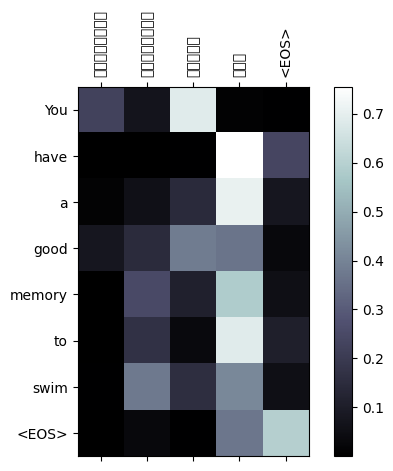

In [74]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

evaluateAndShowAttention('तुम्हारी याददाश्त अच्छी है।')

input = तुम्हारी याददाश्त अच्छी है।
output = You have a good memory to swim <EOS>
BLEU Score: 0.0000


<ipython-input-74-a6c26fbd77a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-74-a6c26fbd77a6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGA

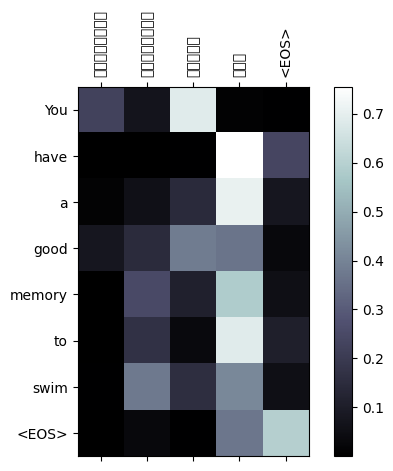

In [75]:
from nltk.translate.bleu_score import sentence_bleu

def evaluateAndShowAttention(input_sentence, reference_translation):
    # Evaluate the translation and attention mechanism
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

    # Compute BLEU score
    reference = reference_translation.split()  # Convert reference translation to a list of words
    candidate = output_words  # Model-generated translation

    # BLEU score computation
    bleu_score = sentence_bleu([reference], candidate)
    print(f"BLEU Score: {bleu_score:.4f}")

    # Pass the attention tensor to the plotting function
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

# Example usage:
reference_translation = 'Your reference translation in English'  # You should provide this
evaluateAndShowAttention('तुम्हारी याददाश्त अच्छी है।', reference_translation)
